In [1]:
from pyhvr import *
from tqdm import tqdm
import datetime
import matplotlib.font_manager
import warnings
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats as sps
import theano
import theano.tensor as tt
from theano.tensor.signal.conv import conv2d

from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, Band, Label, Range1d, BasicTickFormatter, LabelSet, DatetimeTickFormatter, DataRange1d, Span
from bokeh.models.tools import HoverTool
from bokeh.layouts import layout, column, row
from bokeh.io import save
from math import pi

plot_width = 700
plot_height = 500

warnings.simplefilter(action="ignore", category=FutureWarning)
# %config Completer.use_jedi = False
loadstd()

In [2]:
p_delay =  pd.read_csv('data/p_delay.csv', squeeze=True)
ts_mga = pd.read_excel('data/ts_maringa.xlsx')

first_case_date = pd.to_datetime('18/03/2020') # set first case date
ts_mga.Data = ts_mga.Data.apply(pd.to_datetime, format='%d/%m/%Y') 
ts_mga.Data = pd.to_datetime(ts_mga.Data)
ts_mga.sort_values('Data',inplace=True)
ts_mga.reset_index(inplace=True,drop=True)
ts_mga['Confirmados_diario'] = ts_mga.Confirmados.diff(1)
ts_mga.at[0, 'Confirmados_diario'] = 1
    
ts_mga['ativos']=ts_mga['Confirmados']-ts_mga['encerrados_confirmados']-ts_mga['Mortes']
ts_mga['Suspeitos'] = ts_mga['suspeitos_internados'] + ts_mga['suspeitos_acompanhamento']

ts_mga['notificacoes'] = ts_mga[['Confirmados', 'suspeitos_acompanhamento', 'suspeitos_internados', 'encerrados_geral']].sum(axis=1)
ts_mga['notificacoes'] = ts_mga['notificacoes'].diff(1)
ts_mga.at[0, 'notificacoes'] = 15

ts_mga['suspeitos_diario'] = ts_mga['notificacoes']
ts_mga['encerrados_diario'] = ts_mga.sort_values('Data', ascending=True)['encerrados_geral'].diff(1)

ts_mga['testes'] = ts_mga['encerrados_diario'] + ts_mga['Confirmados_diario']

df = ts_mga[['Data', 'Confirmados_diario', 'testes']].copy(deep=True)
df.columns = ['date', 'positive', 'total']
df = df[~df.total.isnull()].set_index('date')

In [3]:
buffer_days = 10 # buffer_days is the default number of
                 # blank days we pad on the leading edge of the time series because
                 # infections occur long before reports and we need to infer values
                 # on those days
observed = df
first_index = observed.positive.ne(0).argmax()
observed = observed.iloc[first_index:]
new_index = pd.date_range(
    start=observed.index[0] - pd.Timedelta(days=buffer_days),
    end=observed.index[-1],
    freq="D",
)
observed = observed.reindex(new_index, fill_value=0)

In [4]:
def _get_generation_time_interval():
    """ Create a discrete P(Generation Interval)
        Source: https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf """
    mean_si = 4.7
    std_si = 2.9
    mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
    sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
    dist = sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

    # Discretize the Generation Interval up to 20 days max
    g_range = np.arange(0, 20)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    gt = gt.diff().fillna(0)
    gt /= gt.sum()
    gt = gt.values
    return gt
def _get_convolution_ready_gt(len_observed):
    """ Speeds up theano.scan by pre-computing the generation time interval
        vector. Thank you to Junpeng Lao for this optimization.
        Please see the outbreak simulation math here:
        https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html """
    gt = _get_generation_time_interval()
    convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
    for t in range(1, len_observed):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1 : t - begin + 1][::-1]
        convolution_ready_gt[
            t - 1, begin : begin + len(slice_update)
        ] = slice_update
    convolution_ready_gt = theano.shared(convolution_ready_gt)
    return convolution_ready_gt

In [5]:
nonzero_days = observed.total.gt(0)
len_observed = len(observed)
convolution_ready_gt = _get_convolution_ready_gt(len_observed)
x = np.arange(len_observed)[:, None]
coords = {
    "date": observed.index.values,
    "nonzero_date": observed.index.values[observed.total.gt(0)],
}
with pm.Model(coords=coords) as model:
    # Let log_r_t walk randomly with a fixed prior of ~0.035. Think
    # of this number as how quickly r_t can react.
    log_r_t = pm.GaussianRandomWalk(
        "log_r_t",
        sigma=0.1,
        dims=["date"]
    )
    r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t), dims=["date"])

    # For a given seed population and R_t curve, we calculate the
    # implied infection curve by simulating an outbreak. While this may
    # look daunting, it's simply a way to recreate the outbreak
    # simulation math inside the model:
    # https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html
    seed = pm.Exponential("seed", 1 / 0.02)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    outputs, _ = theano.scan(
        fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t * y * gt)),
        sequences=[tt.arange(1, len_observed), convolution_ready_gt],
        outputs_info=y0,
        non_sequences=r_t,
        n_steps=len_observed - 1,
    )
    infections = pm.Deterministic("infections", outputs[-1], dims=["date"])

    # Convolve infections to confirmed positive reports based on a known
    # p_delay distribution. See patients.py for details on how we calculate
    # this distribution.
    test_adjusted_positive = pm.Deterministic(
        "test_adjusted_positive",
        conv2d(
            tt.reshape(infections, (1, len_observed)),
            tt.reshape(p_delay, (1, len(p_delay))),
            border_mode="full",
        )[0, :len_observed],
        dims=["date"]
    )

    # Picking an exposure with a prior that exposure never goes below
    # 0.1 * max_tests. The 0.1 only affects early values of Rt when
    # testing was minimal or when data errors cause underreporting
    # of tests.
    tests = pm.Data("tests", observed.total.values, dims=["date"])
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests, observed.total.max() * 0.1, 1e9),
        dims=["date"]
    )

    # Test-volume adjust reported cases based on an assumed exposure
    # Note: this is similar to the exposure parameter in a Poisson
    # regression.
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive,
        dims=["date"]
    )

    # Save data as part of trace so we can access in inference_data
    observed_positive = pm.Data("observed_positive", observed.positive.values, dims=["date"])
    nonzero_observed_positive = pm.Data("nonzero_observed_positive", observed.positive[nonzero_days.values].values, dims=["nonzero_date"])

    positive_nonzero = pm.NegativeBinomial(
        "nonzero_positive",
        mu=positive[nonzero_days.values],
        alpha=pm.Gamma("alpha", mu=6, sigma=1),
        observed=nonzero_observed_positive,
        dims=["nonzero_date"]
    )

    trace = pm.sample(
            cores=4,
            chains=4,
            tune=700,
            draws=200,
            target_accept=.95,
            init="jitter+adapt_diag",
        )    

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 205 seconds.


In [6]:
def summarize_inference_data(inference_data: az.InferenceData):
    """ Summarizes an inference_data object into the form that we publish on rt.live """
    posterior = inference_data.posterior
    hdi_mass = 80
    hpdi = az.hdi(posterior.r_t, hdi_prob=hdi_mass / 100).r_t

    observed_positive = inference_data.constant_data.observed_positive.to_series()
    scale_to_positives = lambda data: observed_positive.mean() / np.mean(data) * data
    tests = inference_data.constant_data.tests.to_series()
    normalized_positive = observed_positive / tests.clip(0.1 * tests.max())

    summary = pd.DataFrame(
        data={
            "mean": posterior.r_t.mean(["draw", "chain"]),
            "median": posterior.r_t.median(["chain", "draw"]),
            f"lower_{hdi_mass}": hpdi[:, 0],
            f"upper_{hdi_mass}": hpdi[:, 1],
            "infections": scale_to_positives(
                posterior.infections.mean(["draw", "chain"])
            ),
            "test_adjusted_positive": scale_to_positives(
                posterior.test_adjusted_positive.mean(["draw", "chain"])
            ),
            "test_adjusted_positive_raw": scale_to_positives(normalized_positive),
            "positive": observed_positive,
            "tests": tests,
        },
        index=pd.Index(posterior.date.values, name="date"),
    )
    return summary
def inference_data():
    """ Returns an Arviz InferenceData object """

    with model:
        posterior_predictive = pm.sample_posterior_predictive(trace)

    _inference_data = az.from_pymc3(
        trace=trace,
        posterior_predictive=posterior_predictive,
    )
    return _inference_data

In [7]:
inference = inference_data()
results = summarize_inference_data(inference)

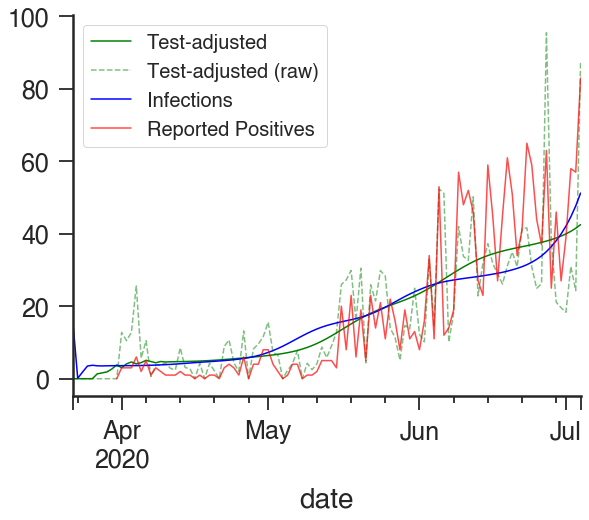

In [9]:
fig, ax = plt.subplots(figsize=stdfigsize())
results.test_adjusted_positive.plot(c="g", label="Test-adjusted")
results.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
results.infections.plot(c="b", label="Infections")
df.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

In [10]:
samples = trace['r_t']
df_rt_live = pd.DataFrame(
    {'date': results.index,
     'mean_r': np.mean(samples, axis=0),
     'lower_5': np.percentile(samples, 5, axis=0),
     'upper_95': np.percentile(samples, 95, axis=0),})

df_rt_r = pd.read_csv('data/rt_r.csv', sep=';')
df_rt_r.columns = ['Unnamed: 0', 't_start', 't_end', 'mean_r', 'Std(R)',
                   'Quantile.0.025(R)', 'lower_5', 'Quantile.0.25(R)',
                   'Median(R)', 'Quantile.0.75(R)', 'upper_95',
                   'Quantile.0.975(R)']
df_rt_r = df_rt_r[['mean_r',
                   'lower_5',
                   'upper_95', 
                   't_start', 
                   't_end']]
for col in ['mean_r','lower_5','upper_95']:
    df_rt_r[col] = [float(i.replace(',', '.')) for i in df_rt_r[col].values]
date_dict = {i: datetime.datetime(2020,3,30)+datetime.timedelta(days=int(i)) for i in np.arange(1,df_rt_r.t_end.max()+1)}
df_rt_r['date'] = pd.to_datetime([date_dict[i] for i in df_rt_r.t_end.values])

In [17]:
filename='rt_efetivo'

source_live = ColumnDataSource(df_rt_live)

fig = figure(x_axis_type="datetime", plot_width=plot_width, plot_height=plot_height, tools="", sizing_mode='stretch_both')

hline = Span(location=1, dimension='width', line_color='#525252', line_width=2, line_dash='dashed')
fig.add_layout(hline)

fig.line(x='date', y='mean_r',
                 source=source_live,
                 line_width=3, color='#2b8cbe', legend_label=f"Efetivo")
band_live = Band(base='date', lower='lower_5', upper='upper_95', 
            fill_alpha=.2, line_width=1, fill_color='#2b8cbe', line_color='#2b8cbe',
            source=source_live)
fig.add_layout(band_live)
c1_live = fig.circle(x='date', y='mean_r',
         source=source_live,
         size=5, color='#2b8cbe')

formatters={'@date': 'datetime'}

hover = HoverTool(formatters=formatters, renderers=[c1_live])
hover.tooltips=[
    ('Data', '@date{%d/%m/%Y}'),
    ('Número de reprodução', '@mean_r'),
]
fig.add_tools(hover)

fig.xaxis.formatter=DatetimeTickFormatter(days=['%d/%m', '%a %d'], months=['%m/%Y', '%b %y'])
fig.yaxis.formatter = BasicTickFormatter(use_scientific=False)

fig.xaxis.axis_label = 'Data'
fig.yaxis.axis_label = 'Número de reprodução efetivo'
fig.y_range = Range1d(df_rt_live['lower_5'].min(), df_rt_live['upper_95'].max())
fig.toolbar.logo = None
fig.toolbar_location = None
fig.xaxis.axis_label_text_font_size = "14pt"
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.major_label_text_font_size = "12pt"
fig.yaxis.major_label_text_font_size = "12pt"
fig.xaxis.axis_label_text_font_style = 'normal'
fig.yaxis.axis_label_text_font_style = 'normal'
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
fig.legend.location = 'top_left'
output_file(f"html/{filename}.html")
save(fig,f"html/{filename}.html")

'/home/andre/github/rt_live_maringa/html/rt_efetivo.html'

In [18]:
filename='rt_instantaneo'

source = ColumnDataSource(df_rt_r)

fig = figure(x_axis_type="datetime", plot_width=plot_width, plot_height=plot_height, tools="", sizing_mode='stretch_both')

hline = Span(location=1, dimension='width', line_color='#525252', line_width=2, line_dash='dashed')
fig.add_layout(hline)

fig.line(x='date', y='mean_r',
                 source=source,
                 line_width=3, color='#ff7f00', legend_label=f"Instantâneo")
band = Band(base='date', lower='lower_5', upper='upper_95', 
            fill_alpha=.2, line_width=1, fill_color='#ff7f00', line_color='#ff7f00',
            source=source)
fig.add_layout(band)
c1 = fig.circle(x='date', y='mean_r',
         source=source,
         size=5, color='#ff7f00')

formatters={'@date': 'datetime'}

hover = HoverTool(formatters=formatters, renderers=[c1])
hover.tooltips=[
    ('Data', '@date{%d/%m/%Y}'),
    ('Número de reprodução', '@mean_r'),
]
fig.add_tools(hover)

fig.xaxis.formatter=DatetimeTickFormatter(days=['%d/%m', '%a %d'], months=['%m/%Y', '%b %y'])
fig.yaxis.formatter = BasicTickFormatter(use_scientific=False)

fig.xaxis.axis_label = 'Data'
fig.yaxis.axis_label = 'Número de reprodução instantâneo'
fig.y_range = Range1d(0, df_rt_r['upper_95'].max())
fig.toolbar.logo = None
fig.toolbar_location = None
fig.xaxis.axis_label_text_font_size = "14pt"
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.major_label_text_font_size = "12pt"
fig.yaxis.major_label_text_font_size = "12pt"
fig.xaxis.axis_label_text_font_style = 'normal'
fig.yaxis.axis_label_text_font_style = 'normal'
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
output_file(f"html/{filename}.html")
save(fig,f"html/{filename}.html")

'/home/andre/github/rt_live_maringa/html/rt_instantaneo.html'